In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms
import numpy as np
import time

In [ ]:
from torch.utils.data import Subset
import numpy as np

def create_balanced_subset(dataset, sample_fraction=0.1):
    labels = np.array([sample[1] for sample in dataset])

    indices = []
    for class_idx in range(100):
        class_indices = np.where(labels == class_idx)[0]
        indices += np.random.choice(class_indices, 50, replace=False).tolist()

    return Subset(dataset, indices)

In [ ]:
# Load the CIFAR-100 dataset, resize them to 224 and convert them to tensor
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose(
    [transforms.Resize(224),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [ ]:
from torch.utils.data import random_split

trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

train_subset = create_balanced_subset(trainset, sample_fraction=0.1)

train_size = int(0.8 * len(train_subset))
val_size = len(train_subset) - train_size
train_subset, val_subset = random_split(train_subset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=2)

test_subset = create_balanced_subset(testset, sample_fraction=0.1)
testloader = torch.utils.data.DataLoader(test_subset, batch_size=32, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Define the MobileNet model
# Define mobilenetv2 object from pytorch models without pre-trained weights.
# Define proper classification layer w.r.t. our dataset.
# Define the proper loss and optimizer.

def create_model_and_optimizer(optimizer_type):
    mobilenet = models.mobilenet_v2(pretrained=False)
    mobilenet.classifier[1] = torch.nn.Linear(mobilenet.last_channel, 100)
    mobilenet = mobilenet.to(DEVICE)

    criterion = torch.nn.CrossEntropyLoss()

    if optimizer_type == "SGD":
        optimizer = optim.SGD(mobilenet.parameters(), lr=0.01)
    elif optimizer_type == "SGD_momentum":
        optimizer = optim.SGD(mobilenet.parameters(), lr=0.01, momentum=0.9)
    elif optimizer_type == "RMSprop":
        optimizer = optim.RMSprop(mobilenet.parameters(), lr=0.01)
    elif optimizer_type == "Adadelta":
        optimizer = optim.Adadelta(mobilenet.parameters(), lr=0.01)
    elif optimizer_type == "Adagrad":
        optimizer = optim.Adagrad(mobilenet.parameters(), lr=0.01)
    elif optimizer_type == "Adam":
        optimizer = optim.Adam(mobilenet.parameters(), lr=0.01)

    return mobilenet, criterion, optimizer

In [ ]:
import time

def train_model_and_track_metrics(optimizer_type):
  mobilenet, criterion, optimizer = create_model_and_optimizer(optimizer_type)

  # Lists to store loss and accuracy
  train_losses = []
  val_losses = []
  train_accuracies = []
  val_accuracies = []

  start_time = time.time()

  # Training loop
  for epoch in range(10):
      running_loss = 0.0
      correct = 0
      total = 0

      # Training phase
      mobilenet.train()
      for i, data in enumerate(trainloader, 0):
          inputs, labels = data

          # move data to device
          inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

          optimizer.zero_grad()

          outputs = mobilenet(inputs)

          loss = criterion(outputs, labels)

          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      train_losses.append(running_loss / len(trainloader))
      train_accuracies.append(100 * correct / total)

      # Validation phase
      mobilenet.eval()
      val_loss = 0.0
      correct = 0
      total = 0

      with torch.no_grad():
          for data in valloader:
              images, labels = data
              images, labels = images.to(DEVICE), labels.to(DEVICE)
              outputs = mobilenet(images)
              loss = criterion(outputs, labels)
              val_loss += loss.item()

              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)

              correct += (predicted == labels).sum().item()

      val_losses.append(val_loss / len(valloader))
      val_accuracies.append(100 * correct / total)

      print(f'Epoch {epoch + 1}, Train Loss: {train_losses[-1]:.3f}, Val Loss: {val_losses[-1]:.3f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Acc: {val_accuracies[-1]:.2f}%')

  mobilenet.eval()
  test_loss = 0.0
  correct = 0
  total = 0

  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images, labels = images.to(DEVICE), labels.to(DEVICE)
          outputs = mobilenet(images)
          loss = criterion(outputs, labels)
          test_loss += loss.item()

          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)

          correct += (predicted == labels).sum().item()

  test_accuracy = 100 * correct / total
  print(f'Test Accuracy: {test_accuracy:.2f}%')

  total_time = time.time() - start_time
  return val_losses, val_accuracies, train_losses, train_accuracies, total_time

In [ ]:
results = []
test_accuracies = []

for optimizer_name in ["SGD", "SGD_momentum", "RMSprop", "Adadelta", "Adagrad", "Adam"]:
  val_losses, val_accuracies, train_losses, train_accuracies, total_time = train_model_and_track_metrics(optimizer_name)

  results.append({
      "Optimizer": optimizer_name,
      "Train Loss": train_losses,
      "Val Loss": val_losses,
      "Train Accuracy": train_accuracies,
      "Val Accuracy": val_accuracies,
      "Total Training Time (s)": total_time
  })

summary_results = []
for result in results:
  summary_results.append({
      "Optimizer": result["Optimizer"],
      "Val Loss (Epoch 1)": result["Val Loss"][0],
      "Val Acc (Epoch 1)": result["Val Accuracy"][0],
      "Val Loss (Epoch 5)": result["Val Loss"][4],
      "Val Acc (Epoch 5)": result["Val Accuracy"][4],
      "Val Loss (Epoch 10)": result["Val Loss"][9],
      "Val Acc (Epoch 10)": result["Val Accuracy"][9],
      "Total Training Time (s)": result["Total Training Time (s)"]
    })

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1, Train Loss: 4.615, Val Loss: 4.644, Train Acc: 1.40%, Val Acc: 0.40%
Epoch 2, Train Loss: 4.543, Val Loss: 4.535, Train Acc: 1.82%, Val Acc: 2.80%
Epoch 3, Train Loss: 4.468, Val Loss: 4.471, Train Acc: 2.88%, Val Acc: 2.70%
Epoch 4, Train Loss: 4.380, Val Loss: 4.350, Train Acc: 3.67%, Val Acc: 3.60%
Epoch 5, Train Loss: 4.269, Val Loss: 4.246, Train Acc: 5.17%, Val Acc: 5.80%
Epoch 6, Train Loss: 4.159, Val Loss: 4.143, Train Acc: 6.08%, Val Acc: 6.10%
Epoch 7, Train Loss: 4.088, Val Loss: 4.104, Train Acc: 6.85%, Val Acc: 7.20%
Epoch 8, Train Loss: 4.002, Val Loss: 4.024, Train Acc: 8.00%, Val Acc: 8.30%
Epoch 9, Train Loss: 3.903, Val Loss: 3.998, Train Acc: 9.97%, Val Acc: 9.00%
Epoch 10, Train Loss: 3.849, Val Loss: 3.931, Train Acc: 10.47%, Val Acc: 10.50%
Test Accuracy: 10.46%
Epoch 1, Train Loss: 4.604, Val Loss: 4.614, Train Acc: 2.27%, Val Acc: 4.40%
Epoch 2, Train Loss: 4.286, Val Loss: 4.309, Train Acc: 5.22%, Val Acc: 4.70%
Epoch 3, Train Loss: 4.082, Val Loss: 4

In [ ]:
df_results = pd.DataFrame(summary_results)
display(df_results)

,Optimizer,Val Loss (Epoch 1),Val Acc (Epoch 1),Val Loss (Epoch 5),Val Acc (Epoch 5),Val Loss (Epoch 10),Val Acc (Epoch 10),Total Training Time (s)
0,SGD,4.644287,0.4,4.245816,5.8,3.931293,10.5,197.975184
1,SGD_momentum,4.614085,4.4,3.955543,10.4,3.850820,16.1,194.369916
2,RMSprop,4.597431,1.6,4.552837,3.2,4.160837,5.1,197.239730
3,Adadelta,4.588637,1.1,4.482157,2.4,4.378437,3.7,197.157200
4,Adagrad,4.362110,2.7,3.896449,11.6,3.862346,12.4,198.016830
5,Adam,4.540014,1.2,4.409895,3.2,4.285546,3.9,195.840317


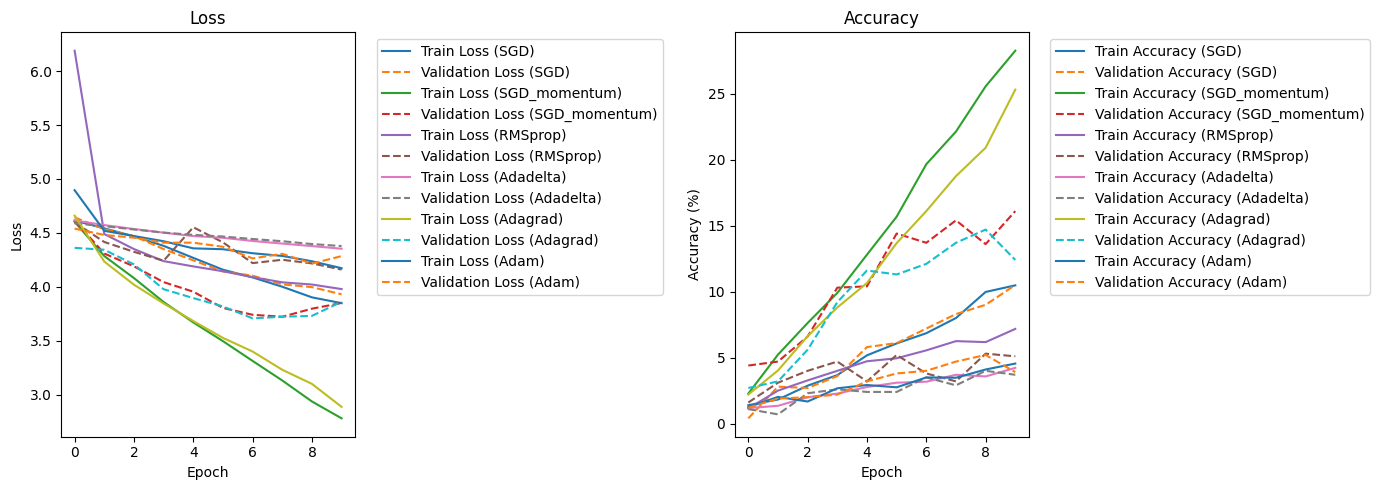

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
for result in results:
  plt.plot(result['Train Loss'], label=f"Train Loss ({result['Optimizer']})")
  plt.plot(result['Val Loss'], label=f"Validation Loss ({result['Optimizer']})", linestyle="--")
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.subplot(1, 2, 2)
for result in results:
  plt.plot(result['Train Accuracy'], label=f"Train Accuracy ({result['Optimizer']})")
  plt.plot(result['Val Accuracy'], label=f"Validation Accuracy ({result['Optimizer']})", linestyle="--")
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()